### py4DSTEM ptychography demo


Last updated: 20240909 - dm852

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

c:\Users\chiahao3\anaconda3\envs\cornell\python.exe
3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)


In [2]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import tifffile
import time

cupyx.jit.rawkernel is experimental. The interface can change in the future.


In [3]:
py4DSTEM.__version__

'0.14.17'

In [4]:
%matplotlib inline

In [5]:
work_dir = "H:\workspace\ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [6]:
## Define the save function for probe, object, scan_positions
def save_py4DSTEM(ptycho, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    with h5py.File(save_dir + '.h5', "w") as f:
        f.create_group('output')
        f['output'].create_dataset('probe', data=ptycho.probe)
        f['output'].create_dataset('object', data=ptycho.object)
        f['output'].create_dataset('probe_pos', data=ptycho.positions)
    f.close()

def get_date(date_format = '%Y%m%d'):
    from datetime import date
    date_format = date_format
    date_str = date.today().strftime(date_format)
    return date_str

# Wrapper to intialize ptycho class
def initialize_ptycho(exp_params):
    if exp_params['Nlayer'] == 1:
        ms_ptycho = py4DSTEM.process.phase.MixedstatePtychography(
            datacube=dataset,
            num_probes = exp_params['pmode_max'],
            verbose=True,
            energy = exp_params['kv']*1e3, # energy in eV
            defocus= exp_params['defocus'], # defocus guess in A
            semiangle_cutoff = exp_params['conv_angle'],
            device='gpu', 
            storage='cpu', 
        )
    else:
        ms_ptycho = py4DSTEM.process.phase.MixedstateMultislicePtychography(
            datacube=dataset,
            num_probes = exp_params['pmode_max'],
            num_slices=exp_params['Nlayer'],
            slice_thicknesses=exp_params['z_distance'],
            verbose=True,
            energy = exp_params['kv']*1e3, # energy in eV
            defocus= exp_params['defocus'], # defocus guess in A
            semiangle_cutoff = exp_params['conv_angle'],
            device='gpu', 
            storage='cpu',
        )
    return ms_ptycho

In [7]:
# Note: py4dstem always estimates an affine transformation instead of taking user input

exp_params = {
    'kv'                : 80, # type: float, unit: kV. Acceleration voltage for relativistic electron wavelength calculation
    'conv_angle'        : 24.9, # type: float, unit: mrad. Semi-convergence angle for probe-forming aperture
    'Npix'              : 128, # type: integer, unit: px (k-space). Detector pixel number, EMPAD is 128. Only supports square detector for simplicity
    'dx_spec'           : 0.1494, # type: float, unit: Ang. Real space pixel size calibration at specimen plane (object, probe, and probe positions share the same pixel size)
    'defocus'           : 0, # type: float, unit: Ang. Defocus (-C1) aberration coefficient for the probe. Positive defocus here refers to actual underfocus or weaker lens strength following Kirkland/abtem/ptychoshelves convention
    'c3'                : 0, # type: float, unit: Ang. Spherical aberration coefficient (Cs) for the probe
    'z_distance'        : 12, # type: float, unit: Ang. Slice thickness for multislice ptychography. Typical values are between 1 to 20 Ang
    'Nlayer'            : 1, # type: int, unit: #. Number of slices for multislice object
    'N_scans'           : 16384, # type: int, unit: #. Number of probe positions (or equivalently diffraction patterns since 1 DP / position)
    'N_scan_slow'       : 128, # type: int, unit: #. Number of scan position along slow scan direction. Usually it's the vertical direction of acquisition GUI
    'N_scan_fast'       : 128, # type: int, unit: #. Number of scan position along fast scan direction. usually it's the horizontal direction of acquisition GUI
    'scan_step_size'    : 0.4290, # type: float, unit: Ang. Step size between probe positions in a rectangular raster scan pattern
    'scan_flipT'        : None, # type: None or list of 3 binary booleans (0 or 1) as [flipup, fliplr, transpose] just like PtychoShleves. Default value is None or equivalently [0,0,0]. This applies additional flip and transpose to initialized scan patterns. Note that modifing 'scan_flipT' would change the image orientation, so it's recommended to set this to None, and only use 'meas_flipT' to get the orientation correct
    'scan_affine'       : None, # type: None or list of 4 floats as [scale, asymmetry, rotation, shear] just like PtychoShleves. Default is None or equivalently [1,0,0,0], rotation and shear are in unit of degree. This applies additional affine transformation to initialized scan patterns to correct sample drift and imperfect scan coils
        # Note: in py4dstem by default global_affine_transformation = False, if set True, the transform is esimated using RANSAC instead of taking user input.
        # rotation angle alone could be either estimated by COM, or set by force_com_rotation = [].
    'pmode_max'         : 6, # type: int, unit: #. Maximum number of mixed probe modes. Set to pmode_max = 1 for single probe state, pmode_max > 1 for mixed-state probe during initialization. For simulated initial object, it'll be generated with the specified number of probe modes. For loaded probe, the pmode dimension would be capped at this number
}

recon_params = {
    'NITER': 1, # type: int. Total number of reconstruction iterations. 1 iteration means a full pass of all selected diffraction patterns. Usually 20-50 iterations can get 90% of the work done with a proper learning rate between 1e-3 to 1e-4. For faster trials in hypertune mode, set 'NITER' to a smaller number than your typical reconstruction to save time. Usually 10-20 iterations are enough for the hypertune parameters to show their relative performance. 
    'BATCH_SIZE': 32, # type: int. Number of diffraction patterns processed simultaneously to get the gradient update. "Batch size" is commonly used in machine learning community, while it's called "grouping" in PtychoShelves. Batch size has an effect on both convergence speed and final quality, usually smaller batch size leads to better final quality for iterative gradient descent, but smaller batch size would also lead to longer computation time per iteration because the GPU isn't as utilized as large batch sizes (due to less GPU parallelism). Generally batch size of 32 to 128 is used, although certain algorithms (like ePIE) would prefer a large batch size that is equal to the dataset size for robustness. For extremely large object (or with a lot of object modes), you'll need to reduce batch_size to save GPU memory as well.
    'step_size': 0.8,
    'output_dir': 'publication/output/tBL-WSe2/', # type str. Path and name of the main output directory. Ideally the 'output_dir' keeps a series of reconstruction of the same materials system or project. The PtyRAD results and figs will be saved into a reconstruction-specific folder under 'output_dir'. The 'output_dir' folder will be automatically created if it doesn't exist.
    'prefix_date': True, # type: boolean. Whether to prefix a date str to the reconstruction folder or not. Set to true to automatically prefix a date str like '20240903_' in front of the reconstruction folder name. Suggested value is true for both reconstruction and hypertune modes. In hypertune mode, the date string would be applied on the hypertune folder instead of the reconsstruction folder. 
    'prefix': '', # type: str. Prefix this string to the reconstruction folder name. Note that "_" will be automatically generated, and the attached str would be after the date str if 'prefix_date' is true. In hypertune mode, the prefix string would be applied on the hypertune folder instead of the reconsstruction folder.  
    'postfix': '', # type: str. Postfix this string to the reconstruction folder name. Note that "_" will be automatically generated. In hypertune mode, the postfix string would be applied on the hypertune folder instead of the reconsstruction folder.  
}

In [8]:
exp_params

{'kv': 80,
 'conv_angle': 24.9,
 'Npix': 128,
 'dx_spec': 0.1494,
 'defocus': 0,
 'c3': 0,
 'z_distance': 12,
 'Nlayer': 1,
 'N_scans': 16384,
 'N_scan_slow': 128,
 'N_scan_fast': 128,
 'scan_step_size': 0.429,
 'scan_flipT': None,
 'scan_affine': None,
 'pmode_max': 6}

In [9]:
file_path = 'H:\workspace\ptyrad_paper/'
file_data = file_path + '/publication/data/tBL_WSe2/Fig_1h_24.9mrad_Themis/1/data_roi1_Ndp128_step128_dp.hdf5'
# dataset = py4DSTEM.read(file_data)
# dataset

with h5py.File(file_data, 'r') as f:
    dataset = py4DSTEM.DataCube(np.reshape(f['dp'],[exp_params['Npix'],exp_params['Npix'],exp_params['N_scan_slow'],exp_params['N_scan_fast']]))

In [10]:
dataset.calibration.set_R_pixel_size(exp_params['scan_step_size'])
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(1/(exp_params['dx_spec']*exp_params['Npix']))
dataset.calibration.set_Q_pixel_units('A^-1')

In [11]:
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.05229250334672021
             R_pixel_size:    0.429
             Q_pixel_units:   A^-1
             R_pixel_units:   A
             QR_flip:         False
)

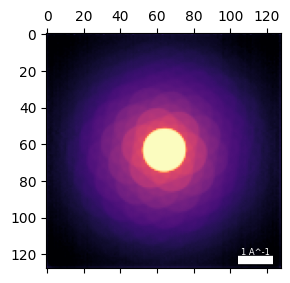

In [12]:
py4DSTEM.show(
    dataset.get_dp_mean(),
    cmap = 'magma',
    scaling = 'log',
    figsize = (3,3),
)

Estimated probe center = qx = 63.15, qy = 63.97 pixels
Estimated probe radius = 11.61 pixels


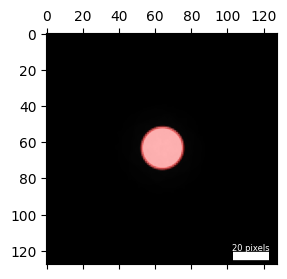

In [13]:
probe_radius_pixels, probe_qx0, probe_qy0 = dataset.get_probe_size(
    dataset.tree('dp_mean').data,
    plot = True,
    figsize = (3,3),
)

# Print the estimated center and probe radius
print('Estimated probe center =', 'qx = %.2f, qy = %.2f' % (probe_qx0, probe_qy0), 'pixels')
print('Estimated probe radius =', '%.2f' % probe_radius_pixels, 'pixels')

100%|██████████| 16384/16384 [00:00<00:00, 23404.03it/s]


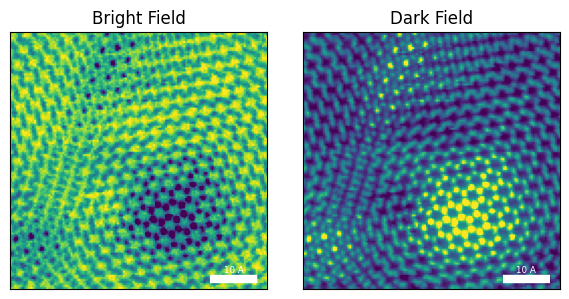

In [14]:
# Make a virtual bright field and dark field image
expand_BF = 2.0  # expand radius by 2 pixels to encompass the full center disk

center = (probe_qx0, probe_qy0)
radius_BF = probe_radius_pixels + expand_BF
radii_DF = (probe_radius_pixels + expand_BF, 1e3)

dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
    shift_center = False,
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
    shift_center = False,
);

# plot the virtual images
py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),               
    ],
    cmap='viridis',
    ticks = False,
    axsize=(3,3),
    title=['Bright Field','Dark Field'],
)

Best fit rotation forced to 93 degrees.
Diffraction intensities should be transposed.
Normalizing amplitudes: 100%|██████████| 16384/16384 [00:03<00:00, 5426.65probe position/s]


MixedstatePtychography( A Node called 'mixed-state_ptychographic_reconstruction', containing the following top-level objects in its tree:

)

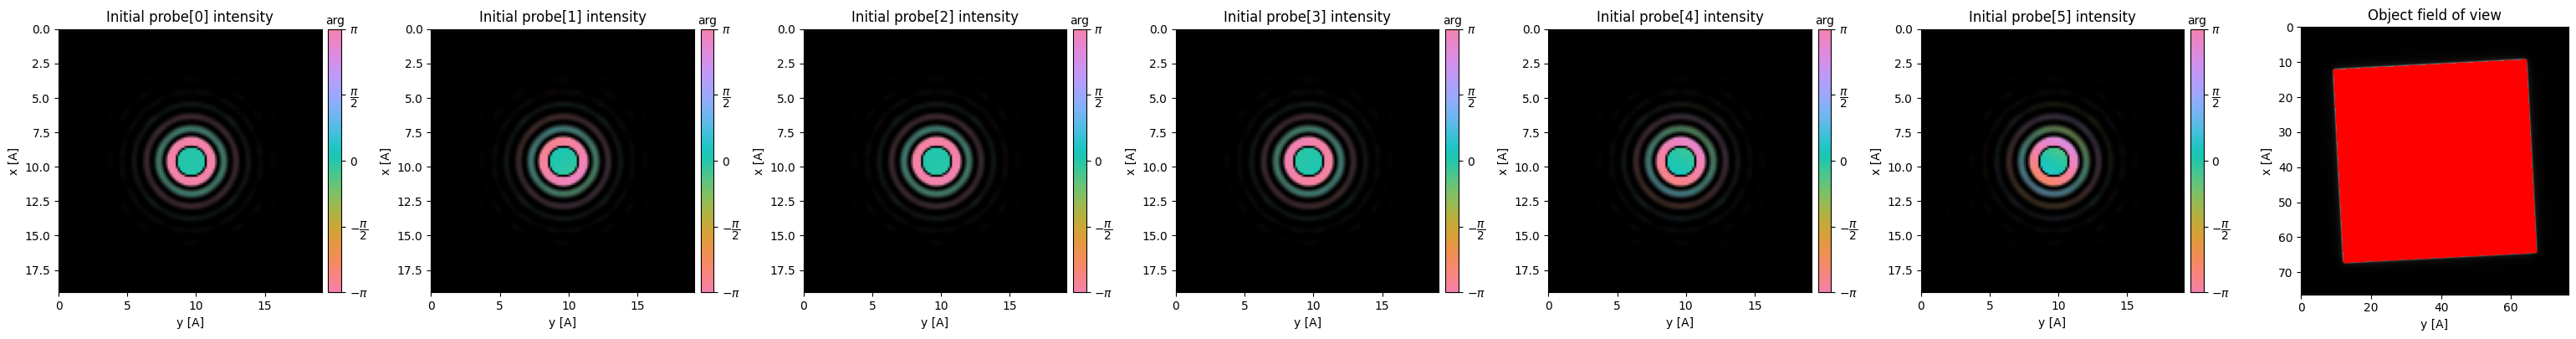

In [15]:
ms_ptycho = initialize_ptycho(exp_params)
ms_ptycho.preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    # plot_probe_overlaps=False,
    force_com_rotation = 93,
)

Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.8, in batches of max 32 measurements.
Reconstructing object and probe: 100%|██████████| 1/1 [00:36<00:00, 36.17s/ iter]


MixedstatePtychography( A Node called 'mixed-state_ptychographic_reconstruction', containing the following top-level objects in its tree:

)

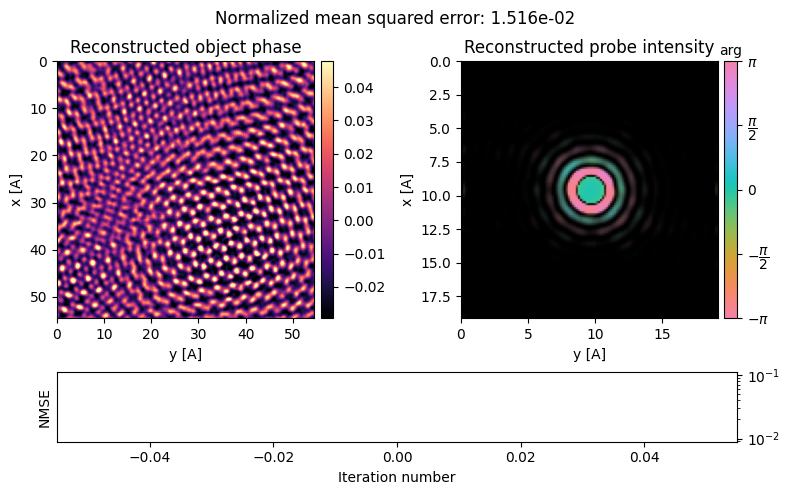

In [16]:
ms_ptycho.reconstruct(
    reset=True,
    store_iterations=True,
    num_iter = recon_params['NITER'],
    normalization_min=1,
    step_size = recon_params['step_size'],
    #gaussian_filter_sigma = .5,
    #kz_regularization_gamma = 1000,
    #reconstruction_method = 'RAAR'
    max_batch_size = recon_params['BATCH_SIZE'],
).visualize(
    iterations_grid = 'auto'
)

In [28]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [32]:
ms_ptycho.object_iterations

[array([[1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j, ...,
         1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j],
        [1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j, ...,
         1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j],
        [1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j, ...,
         1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j],
        ...,
        [1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j, ...,
         1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j],
        [1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j, ...,
         1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j],
        [1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j, ...,
         1.-1.9881161e-05j, 1.-1.9881161e-05j, 1.-1.9881161e-05j]],
       dtype=complex64)]

In [ ]:
# Preprocess prefix and postfix
prefix = recon_params['prefix']
prefix  = prefix+ '_' if prefix  != '' else '' + 'py4DSTEM' + '_'
prefix = get_date() + '_' + prefix 

output_dir = recon_params['output_dir']
save_dir  = file_path + output_dir + prefix + f"N{(exp_params['N_scan_slow']*exp_params['N_scan_fast'])}_dp{exp_params['Npix']}_Nlayer{exp_params['Nlayer']}" 
save_py4DSTEM(ms_ptycho, save_dir)

In [ ]:
save_dir

In [ ]:
print('Printing summary')
print('Loaded measurement data from:', file_data)
print('4D data shape:', dataset.shape)
print('Ptycho engine:', ms_ptycho.__class__)
print("Saved results to:", save_dir+'.h5')
print('probe shape:', ms_ptycho.probe.shape)
print('object shape:', ms_ptycho.object.shape)
print('Total iterations:', recon_params['NITER'])
# print('Total time comsumption:', endtime - starttime)